### Version 05 
In this version, we switched `HashVectorizer()` to `CountVectorizer()`. While true positive rate for key models improved, false positive rate also went up.

In [7]:
# all imports and magic commands
import re
# import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# text preprocessing
from nltk.tokenize import word_tokenize

from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [8]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [71]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    
    movie_data['review_cleaned']=None
   #https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string 
    CLEANR = re.compile('<.*?>') 
    
    def cleanhtml(raw_html):
        removehtml = re.sub(CLEANR, '', raw_html)
        cleantext = re.sub(r'\W+', ' ', removehtml)
        return cleantext.lower()

    for i in range(len(movie_data)):
        movie_data['review_cleaned'][i] = cleanhtml(movie_data.review[i])
    
    
    reviews = movie_data.review
    reviews_cleaned = movie_data.review_cleaned
    
    print(movie_data.head(10))
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer()
        X_hv = hv.fit_transform(reviews_cleaned)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(reviews)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = reviews_cleaned.str.split(' ').str.len()
    movie_data['punc_count'] = reviews_cleaned.str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [72]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

<ipython-input-71-1c97b1c3e038>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['review_cleaned'][i] = cleanhtml(movie_data.review[i])


        id  sentiment                                             review  \
0   5814_8          1  With all this stuff going down at the moment w...   
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...   
2   7759_3          0  The film starts with a manager (Nicholas Bell)...   
3   3630_4          0  It must be assumed that those who praised this...   
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...   
5   8196_8          1  I dont know why people think this is such a ba...   
6   7166_2          0  This movie could have been very good, but come...   
7  10633_1          0  I watched this video at a friend's house. I'm ...   
8    319_1          0  A friend of mine bought this film for £1, and ...   
9  8713_10          1  <br /><br />This movie is full of references. ...   

                                      review_cleaned  
0  with all this stuff going down at the moment w...  
1   the classic war of the worlds by timothy hine... 

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [73]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)
print("performance_measures is:", type(ols_performance_train.performance_measures))

{'Pos': 10000, 'Neg': 10000, 'TP': 4907, 'TN': 5195, 'FP': 4805, 'FN': 5093, 'Accuracy': 0.5051, 'Precision': 0.5052512355848435, 'Recall': 0.4907, 'desc': 'ols_train'}
performance_measures is: <class 'dict'>


### MODEL: SVM, linear

In [74]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [75]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [76]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 9703, 'TN': 9904, 'FP': 96, 'FN': 297, 'Accuracy': 0.98035, 'Precision': 0.9902030819471375, 'Recall': 0.9703, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [77]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [78]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [79]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 8193, 'TN': 7392, 'FP': 2608, 'FN': 1807, 'Accuracy': 0.77925, 'Precision': 0.7585408758448292, 'Recall': 0.8193, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

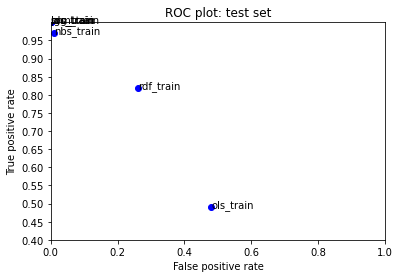

In [80]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [81]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
train_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
train_table = train_table.reindex(column_order, axis=1)

print(train_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
logistic reg                   1.0000               0.0000
perceptron                     1.0000               0.0000
ridge reg                      1.0000               0.0000
support vector                 1.0000               0.0000
naive bayes                    0.9703               0.0096
random forest                  0.8193               0.2608
ordinary least sq              0.4907               0.4805


### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [82]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [83]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review_cleaned'])
                print('* * * * * * * * * ')


Examples of false positives:
43
now i love bela lugosi don t get me wrong he is one of the most interesting people to ever make a movie but he certainly did his share of clunkers this is just another one of those lugosi plays dr lorenz a doctor who has had his medical license pulled for unexplained reasons he is however doing experiments to keep his wife young and beautiful it s revealed that she is 70 80 years old yet lugosi looks to be in his mid 50 s so why he is married to this old woman is never really explained anyway these treatments or experiments involved giving brides who are at the altar being married some sort of sweet smelling substance whereby they pass out but are thought to be dead then lugosi and some of his assistants steal the body on its way to the morgue and take it back to his lab where it s kept in some sort of suspended animation or catatonic state then the stolen brides have a needle rammed somewhere in their bodies maybe the neck and then the needle is rammed 

3695
i saw this movie with some indian friends on christmas day the quick summary of this movie is must avoid jp dutta wrote directed produced and edited this movie and did none of these jobs well the movie tells the story of the attempt by pakistan in 1999 to capture part of the disputed region of kashmir from india supposedly based on fact you get a hint from this movie of the difficulty the indian army had in recapturing the area from the pakistani troops who occupied the high ground but instead of telling what must have been a compelling and heroic story all this movie does is make the indian military look laughable and stupid which i know is not true i watched this movie with an almost completely indian audience who were very patriotic and clearly wanted to like this movie but also found themselves laughing at scenes that weren t meant to be funny the script was absolutely abysmal it gave the impression that mr dutta knows nothing about how an army operates and was using bad war m

7296
the idea was awesome the actors were incredible the story could of been very scary but the writing was poor and there was no depth i couldn t really get into this movie i couldn t feel for the characters there were a lot of cliffhangers and the movie just ends very weirdly was it a happy ending i don t know was it a sad ending again i don t know you leave the theater feeling unsatisfied the movie had so much to give but couldn t just because you can edit doesn t mean you should right i wouldn t really recommend this movie because you just can t say that you left the movie feeling like it was completed you ll just be confused trust me you will probably thank me if you don t watch this movie 3 10
* * * * * * * * * 
7401
this film seems to be completely pointless there is no reason why anything that happens in it happens as if it was written by a small child who got bored halfway through and thought how can i wrap this up and what were jared harris and christopher walken thinking did

11168
bad actors terrible script totally unbelievable ending this film had it all after seeing films like this you wonder why the makers bothered at all this film has absolutely nothing to say all the methods used to create a scare have been used over and over again in previous horror films a total waste of time 
* * * * * * * * * 
11207
essentially a story of man versus nature this film has beautiful cinematography the lush jungles of ceylon and the presence of elizabeth taylor but the film really never gets going newlwed taylor is ignored and neglected by her husband and later is drawn to the plantation s foreman played by dana andrews the plantation is under the spell of owner peter finch s late father whose ghost casts a pall over elephant walk that becomes a major point of contention between taylor and finch the elephants are determined to reclaim their traditional path to water that was blocked when the mansion was built across their right of way the beasts go on a rampage and pr

14924
beast wars is a show that is over hyped overpraised and overrated let s meet the characters of this obnoxious show whose creators must have been on acid to try and make a show like this cheetor seriously they need to have censor bars on this guy how come he dosen t creep out the viewers having the same voice as baby taz at least razzoff from rayman 3 hoodlum havoc is voiced by slip slide action blast if you want a line of show that suck get g4 tranceformers cybertron a show that should go down in a toilet good job creators sarcasm show it self retarded boring at least the super mario games are better this show had a lot of followers sayin bring it back but i believe that it was cancelled for its own good 
* * * * * * * * * 
14947
this is a decent endeavor but the guy who wrote the screenplay seems to be a bit in the dark as to what exactly makes a zombie movie cool no it isn t cgi bugs and software companies actually i m not sure whether it was a software company i saw it without

18461
ironically although he can do the splits thomas is a complete stiff as an actor this film is seared into my memory as one of the most side splittingly cheesy and incompetent movies i have ever seen as such i m actually rather fond of it still the only reason this gets more than one star is that thomas is great shape and it s fun to see his tiny muscular body performing various feats of gymnastic skill on the oddly shaped rocks and poles scattered about the east european country side including the infamous pommel horse shaped well cap in the middle of a village square that thomas uses to plant his feet in the faces of various insane villagers but let the poor guy open his mouth and try to emote and any illusion that he might have a film career is immediately dashed to bits thomas at least had the excuse that he wasn t really an actor everyone else in the film actors director editor camera guys etc is at least as bad or even worse and most of them are professionals so kurt doesn t 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [84]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1223, 'TN': 1337, 'FP': 1163, 'FN': 1277, 'Accuracy': 0.512, 'Precision': 0.5125733445096395, 'Recall': 0.4892, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [85]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2090, 'TN': 2098, 'FP': 402, 'FN': 410, 'Accuracy': 0.8376, 'Precision': 0.8386837881219904, 'Recall': 0.836, 'desc': 'svm_test'}


### MODEL: logistic regression

In [86]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2064, 'TN': 2116, 'FP': 384, 'FN': 436, 'Accuracy': 0.836, 'Precision': 0.8431372549019608, 'Recall': 0.8256, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [87]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1862, 'TN': 1897, 'FP': 603, 'FN': 638, 'Accuracy': 0.7518, 'Precision': 0.7553752535496957, 'Recall': 0.7448, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [88]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2076, 'TN': 2104, 'FP': 396, 'FN': 424, 'Accuracy': 0.836, 'Precision': 0.8398058252427184, 'Recall': 0.8304, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [89]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2141, 'TN': 2066, 'FP': 434, 'FN': 359, 'Accuracy': 0.8414, 'Precision': 0.8314563106796117, 'Recall': 0.8564, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [90]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)
print(rdf_performance_test)

{'Pos': 2500, 'Neg': 2500, 'TP': 1993, 'TN': 1826, 'FP': 674, 'FN': 507, 'Accuracy': 0.7638, 'Precision': 0.7472815898012748, 'Recall': 0.7972, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

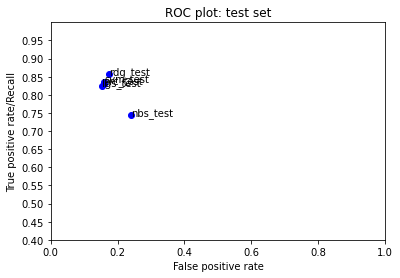

In [91]:
fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('True positive rate/Recall')
plt.xlabel('False positive rate')
plt.show()

### Create Pivot Table

In [92]:
#https://pavopax.github.io/2017/11/precision-recall/
#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba#:~:text=Recall%20and%20True%20Positive%20Rate,denominator%20contains%20the%20true%20negatives.
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
TP_rate =[]
FP_rate =[]
rows = ['ordinary least sq','support vector','logistic reg','naive bayes','perceptron','ridge reg','random forest']
for fit in fits:
    FP_rate.append(fit.performance_measures['FP'] / fit.performance_measures['Neg'])
    TP_rate.append(fit.performance_measures['TP'] / fit.performance_measures['Pos'])
    
df = pd.DataFrame({"True Positive Rate":TP_rate, "False Positive Rate": FP_rate, "Rows": rows})
test_table = pd.pivot_table(df, values=["True Positive Rate","False Positive Rate"], index=["Rows"]).sort_values(by=['True Positive Rate'],ascending=False)

column_order=["True Positive Rate","False Positive Rate"]
test_table = test_table.reindex(column_order, axis=1)

print(test_table)

                   True Positive Rate  False Positive Rate
Rows                                                      
ridge reg                      0.8564               0.1736
support vector                 0.8360               0.1608
perceptron                     0.8304               0.1584
logistic reg                   0.8256               0.1536
random forest                  0.7972               0.2696
naive bayes                    0.7448               0.2412
ordinary least sq              0.4892               0.4652


---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           5
1         169          15
2         176          18
3         112           5
4         133           8
5         331          20
6         121          18
7         230          22
8          59           3
9         224          14
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation